In [3]:
import sys

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

In [122]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    APLpath = APLpath + 'apl.json'
    #try:
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
    #except:
    #    print('apl.json not found from' + APLpath)
        
def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid/(2*APL)

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    ThicknessPath = ThicknessPath + 'thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)
    #except:
    #    pass
    #    print('thickness.json not found from' + system['path'])
    

def calcLipidFraction(system, lipid):
    NlipidTOT = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidTOT += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if lipid in molecule:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Nlipid/NlipidTOT

def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid


def getHydrationLevel(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    return Nwater/Nlipid

def getWaterPermeationRate(system):
    path = system['path']
    with open(path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    rate = count / (time * area)
    return rate

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = path.replace('../Data/MD-PERMEATION/', '../Data/WATERdiffusion/')
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')

In [126]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    try:
        rate = getWaterPermeationRate(system)
    except:
        print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = float('nan')

    area = calcArea(system)    
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'temperature': temperature ,
        'permeation': rate, 
        'APL': APL, 
        'CholFraction': CholFraction,
        'POPGFraction': POPGFraction,
        'POPSFraction': POPSFraction,
        'POPEFraction': POPEFraction,
        'hydration': hydration,
        'thickness': thickness,
        'ChargedFraction': ChargedFraction,
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        'area' : area
    }
        
        
    #!ls {path}
    #for key in system:
    #    print(key, ':',system[key])
    #print('')

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/16a/a70/16aa70c118dbfdbb7bd8e0462575e2776e0dec9a/ba8633f6385dbf4c344b8a7580603620b0d52603/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/8d8/5c6/8d85c662a53e14e285a3bcfb75c55f3fef35be4b/343a5f2b56bf580ab0e4fb5d444c2c947c825dd3/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/9a1/605/9a16054f3de88c6236c869a48b7ba22a4560c031/1ee911c0a7597ddccc6a2f88e6de0103731df881/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/1c6/213/1c62137370ddb732012f431ecd647f8490b243f1/19e060bb4e007489a0da5936e99d20c97097ffd0/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/371/d53/371d534a1bb41fd81e137717e473e6916c9bbf70/7c24007a3d9cbe605a31999850e929ebfaf530f7/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/7f6/fbc/7f6fbc9ec469b1d33d2ec93cccdd86768443988f/f7a6d748844cb56fec39dd0c2f27b9483a291114/
Water permeation failed, setting rate to 0: ../Data/MD-PER

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/a00/2c2/a002c28997069825fa42a6b751369d8062533e14/757216c36b032096aca0f434eba8799fcd5e3860/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/294/580/294580f76f29b1bd472b1bfd3ac96bd2c0afc3d8/f9d04d782c95d988832179eb8bf7e78380039dbc/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/d56/af7/d56af76f2bc3c77ecb6b255dd1e6e4a304621a22/98cde4f05842054793d2430b174329e176982042/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/d44/b08/d44b08236b42139f46a3fbbbd840e239070fb0b8/60bc71c1212d826e4842a448c90cbd8506142e69/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/351/942/3519421ff6c7df40e1da7ac6b6e9ea4d06c911ca/1419f364222a22aadc90d4ec0963e18173e1df2a/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/cc4/a40/cc4a403b0e807a109f793c4acf8d4893f5db01bc/6ec5d72af3c2ccb3d149982aa549b9647c8c7a8e/
Water permeation failed, setting rate to 0: ../Data/MD-PER

(0.0, 0.2)

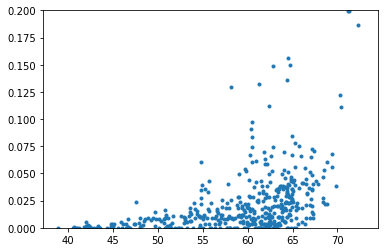

In [103]:
plotCorrelation('APL','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(3.0, 6.0)

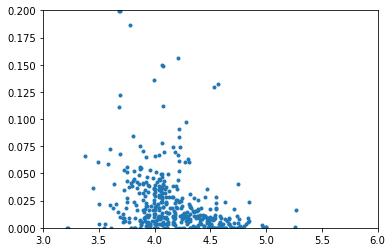

In [88]:
plotCorrelation('thickness','permeation',permeationVStemperature)
plt.ylim([0,0.2])
plt.xlim([3,6])

(0.0, 0.2)

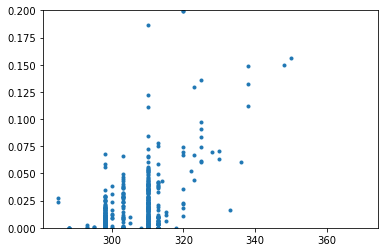

In [8]:
plotCorrelation('temperature','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

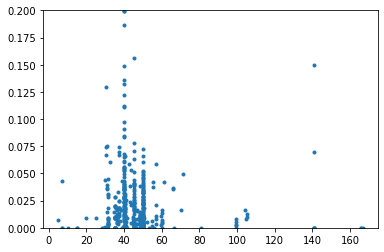

In [9]:
plotCorrelation('hydration','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 11.0)

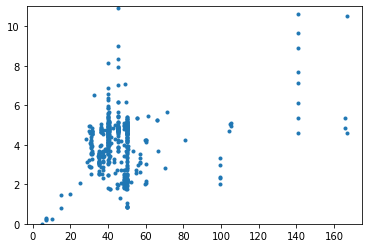

In [104]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperature)
plt.ylim([0,11])

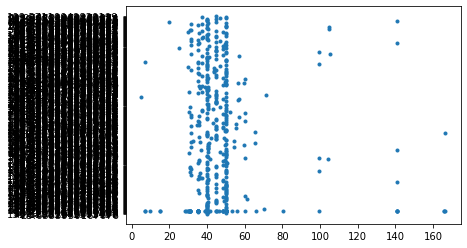

In [97]:
plotCorrelation('hydration','PermeationDiffusionRatio',permeationVStemperature)
#plt.ylim([0,0.05])

(0.0, 0.2)

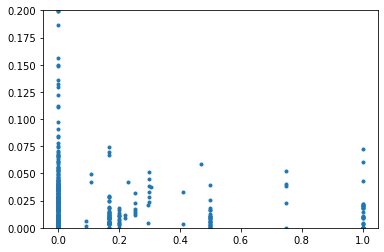

In [10]:
plotCorrelation('ChargedFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

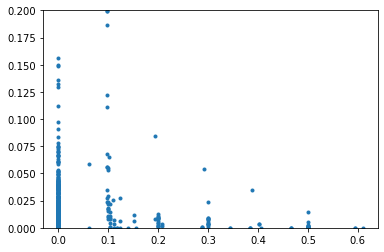

In [49]:
plotCorrelation('CholFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

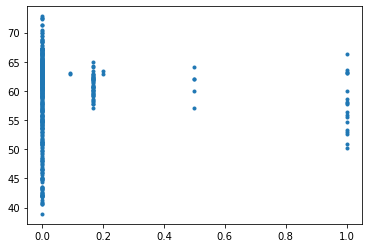

In [63]:
plotCorrelation('POPSFraction','APL',permeationVStemperature)

In [127]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

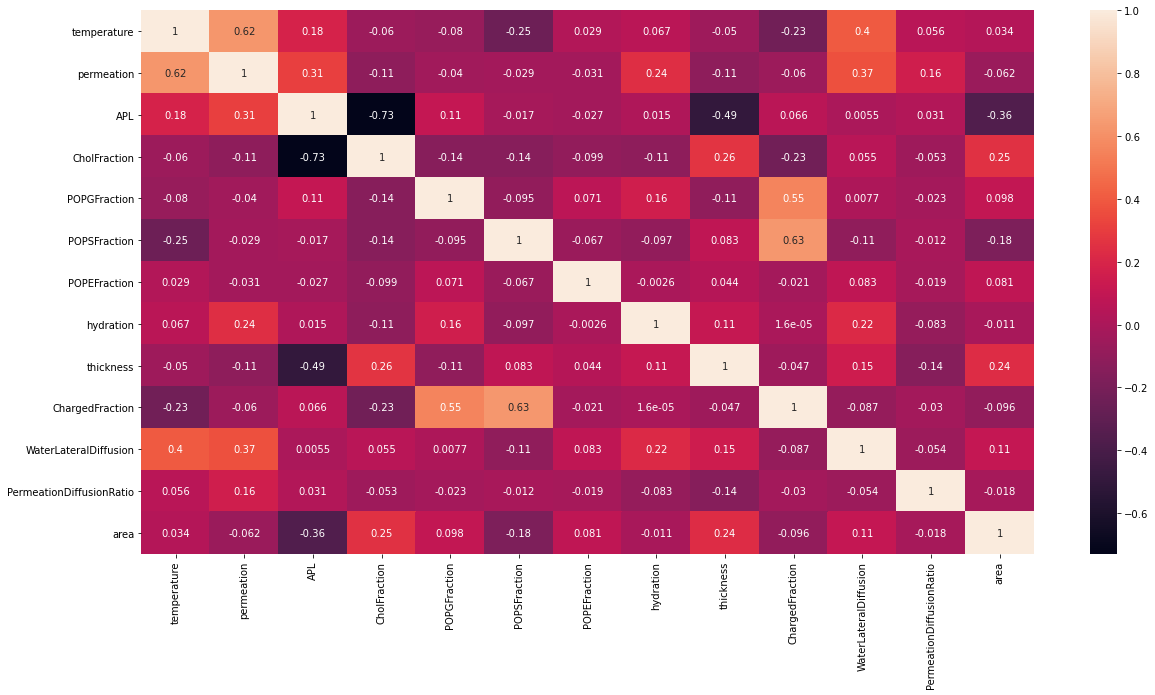

In [128]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [87]:
print(df)

     temperature  permeation        APL  hydration  thickness  \
0         333.00    0.317920  72.437426  40.000000   3.686595   
1         303.15    0.028421  60.630410  50.000000   4.101672   
2         338.00    0.149173  62.809820  40.000000   4.077170   
3         298.00    0.008800  56.322969  35.000000   4.466391   
4         295.00    0.000686  44.772900  40.312500   4.997551   
..           ...         ...        ...        ...        ...   
467       298.00    0.016673  64.023995  46.763672   4.000536   
468       320.00    0.074260  62.841118  37.246667   4.168314   
469       298.15    0.000000  43.417934  50.000000   4.759935   
470       313.00    0.009910  63.423311  50.000000   3.998081   
471       310.15    0.044296  65.141694  45.000000   4.049615   

     WaterLateralDiffusion  PermeationDiffusionRatio  
0                   8.1500                  0.039009  
1                   4.5294                  0.006275  
2                   6.2846                  0.023736  